In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.optimizers import Adam
from keras.layers import Activation, Dense, Input, Dropout, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.layers import BatchNormalization
from keras.layers.merge import concatenate
from keras.models import Model, Sequential, load_model, clone_model
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.spatial import distance
import numpy as np

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.



C:\Users\asmit\Anaconda3\envs\Conda 3.7(64-bit)\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
C:\Users\asmit\Anaconda3\envs\Conda 3.7(64-bit)\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


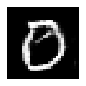

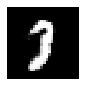

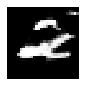

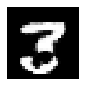

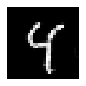

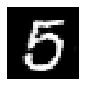

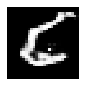

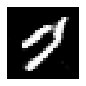

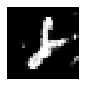

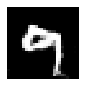

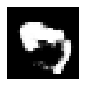

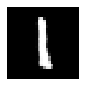

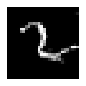

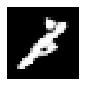

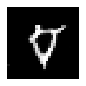

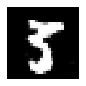

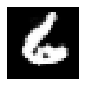

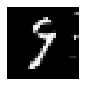

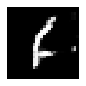

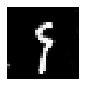

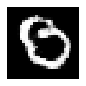

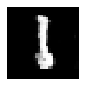

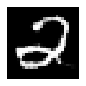

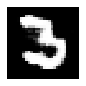

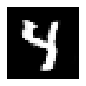

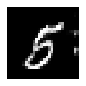

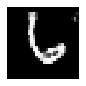

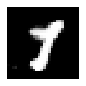

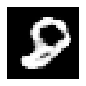

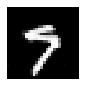

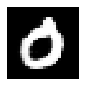

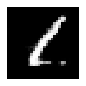

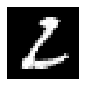

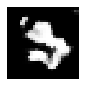

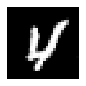

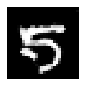

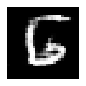

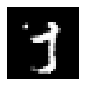

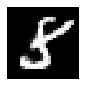

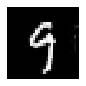

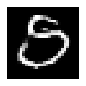

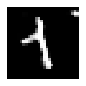

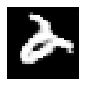

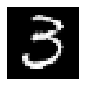

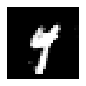

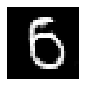

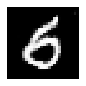

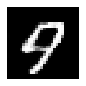

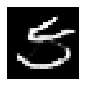

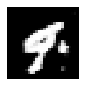

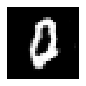

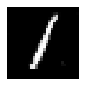

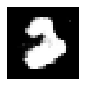

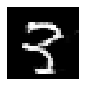

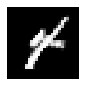

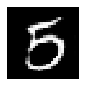

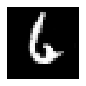

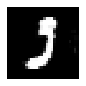

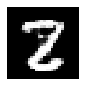

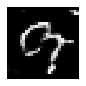

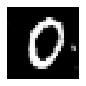

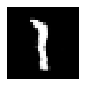

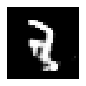

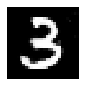

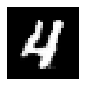

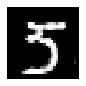

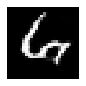

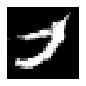

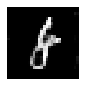

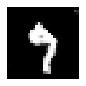

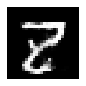

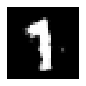

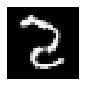

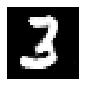

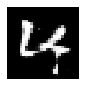

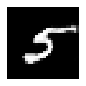

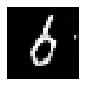

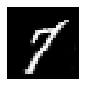

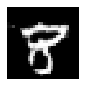

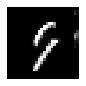

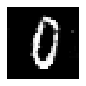

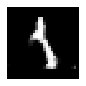

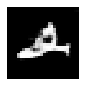

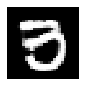

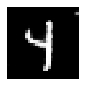

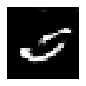

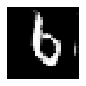

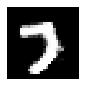

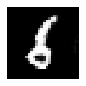

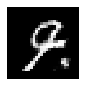

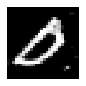

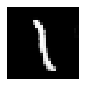

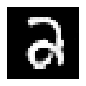

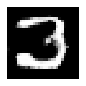

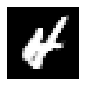

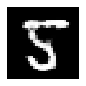

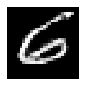

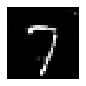

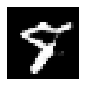

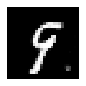

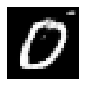

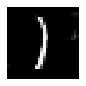

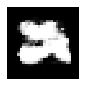

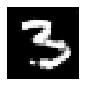

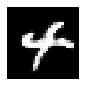

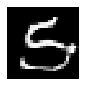

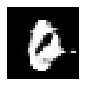

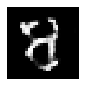

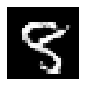

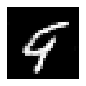

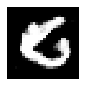

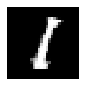

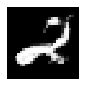

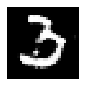

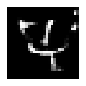

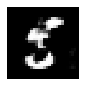

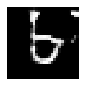

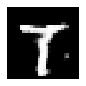

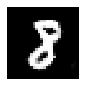

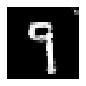

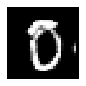

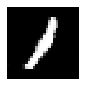

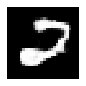

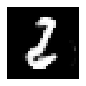

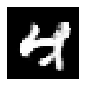

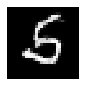

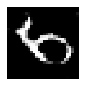

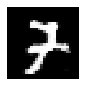

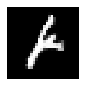

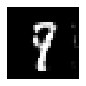

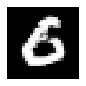

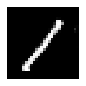

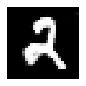

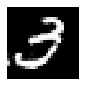

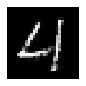

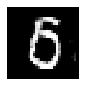

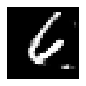

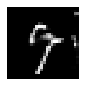

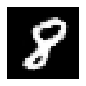

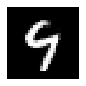

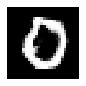

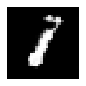

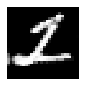

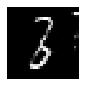

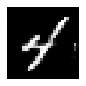

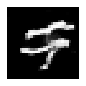

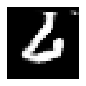

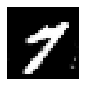

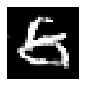

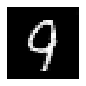

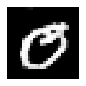

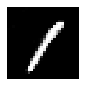

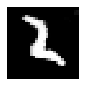

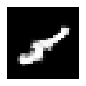

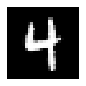

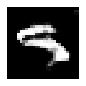

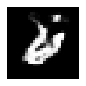

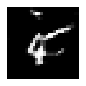

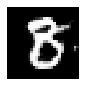

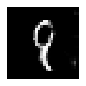

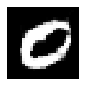

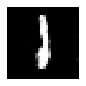

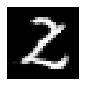

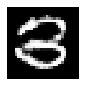

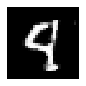

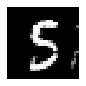

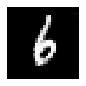

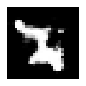

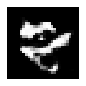

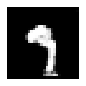

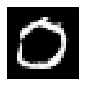

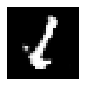

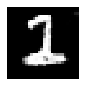

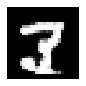

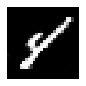

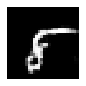

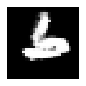

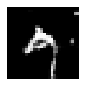

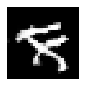

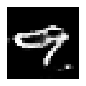

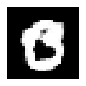

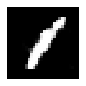

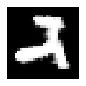

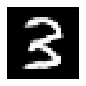

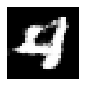

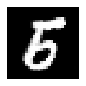

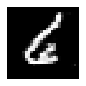

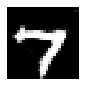

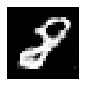

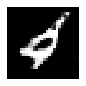

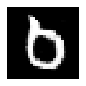

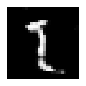

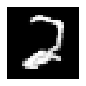

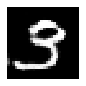

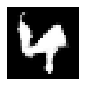

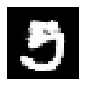

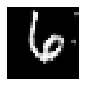

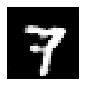

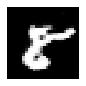

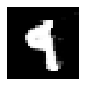

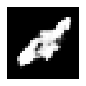

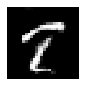

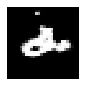

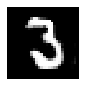

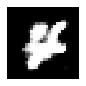

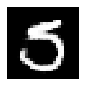

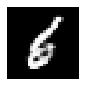

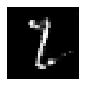

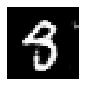

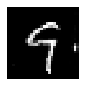

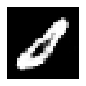

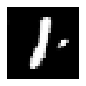

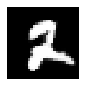

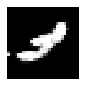

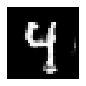

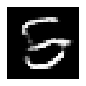

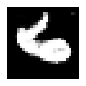

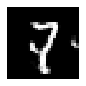

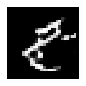

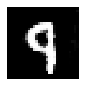

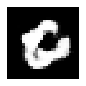

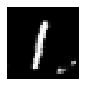

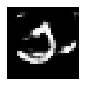

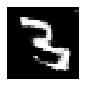

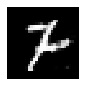

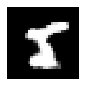

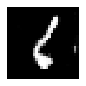

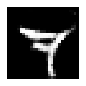

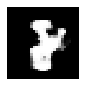

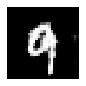

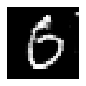

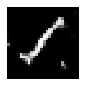

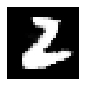

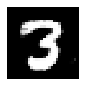

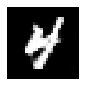

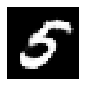

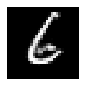

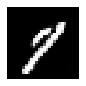

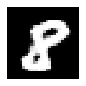

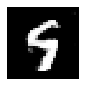

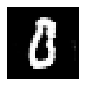

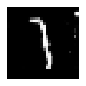

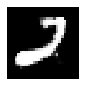

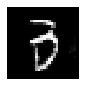

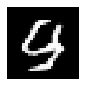

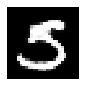

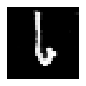

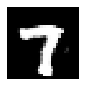

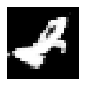

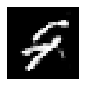

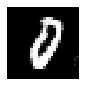

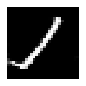

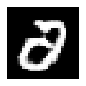

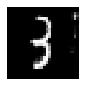

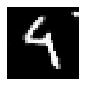

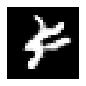

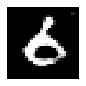

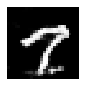

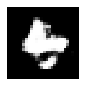

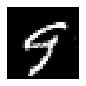

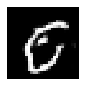

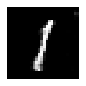

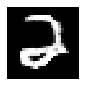

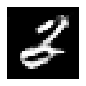

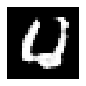

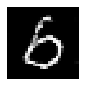

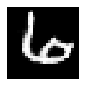

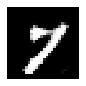

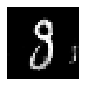

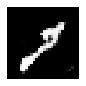

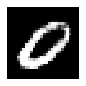

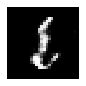

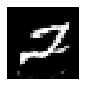

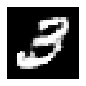

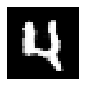

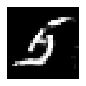

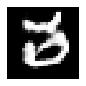

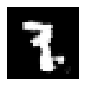

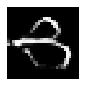

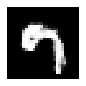

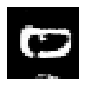

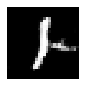

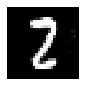

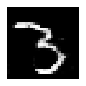

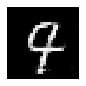

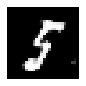

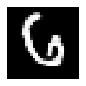

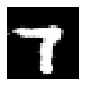

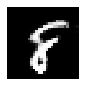

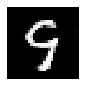

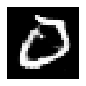

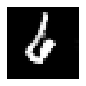

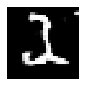

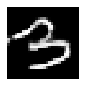

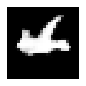

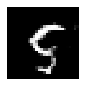

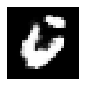

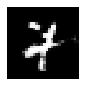

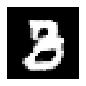

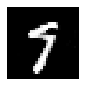

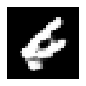

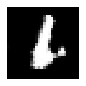

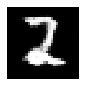

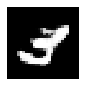

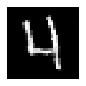

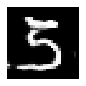

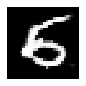

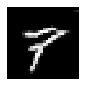

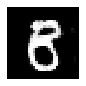

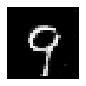

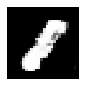

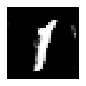

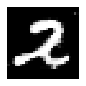

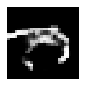

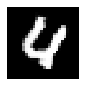

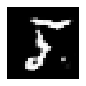

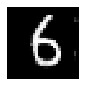

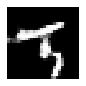

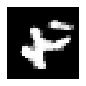

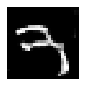

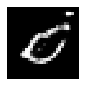

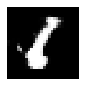

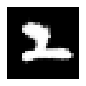

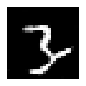

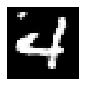

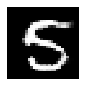

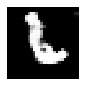

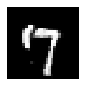

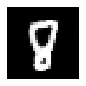

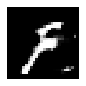

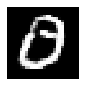

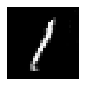

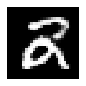

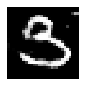

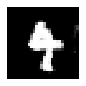

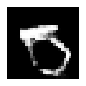

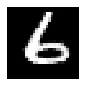

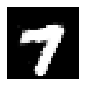

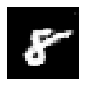

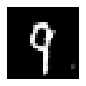

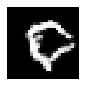

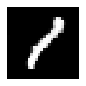

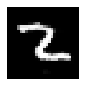

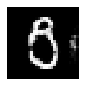

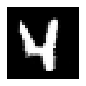

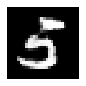

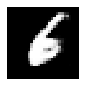

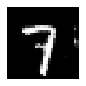

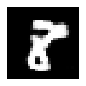

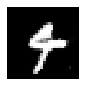

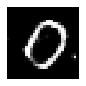

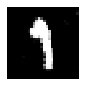

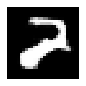

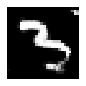

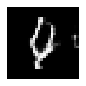

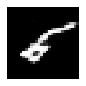

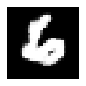

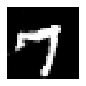

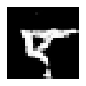

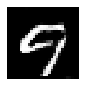

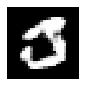

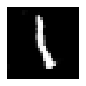

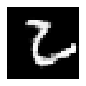

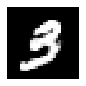

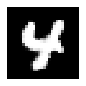

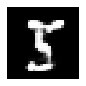

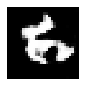

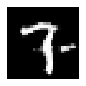

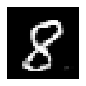

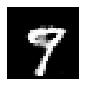

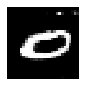

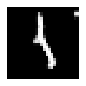

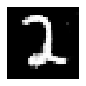

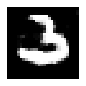

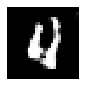

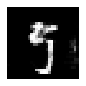

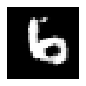

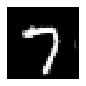

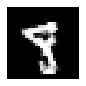

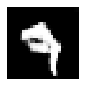

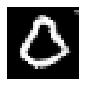

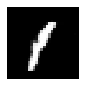

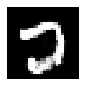

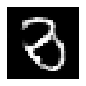

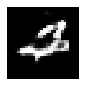

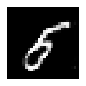

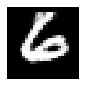

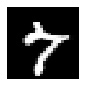

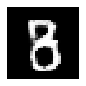

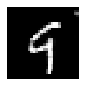

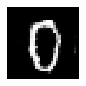

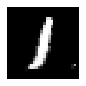

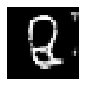

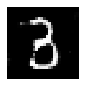

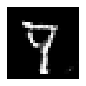

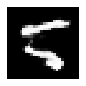

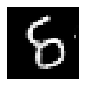

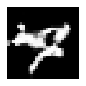

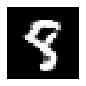

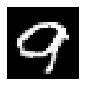

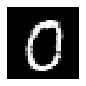

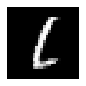

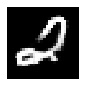

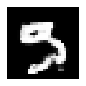

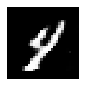

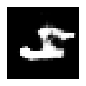

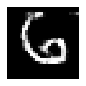

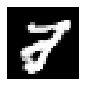

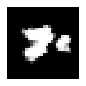

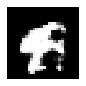

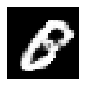

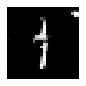

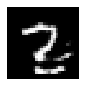

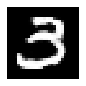

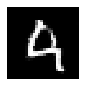

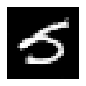

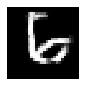

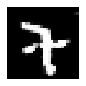

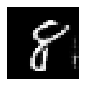

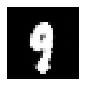

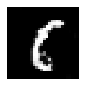

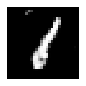

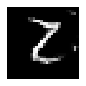

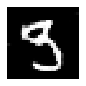

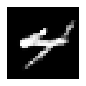

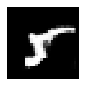

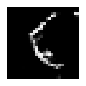

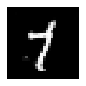

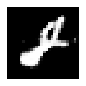

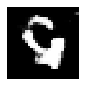

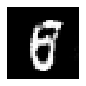

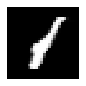

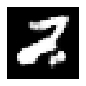

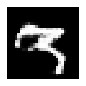

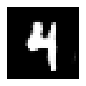

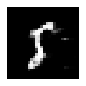

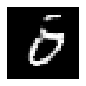

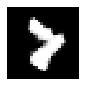

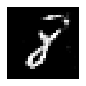

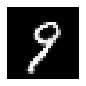

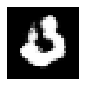

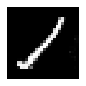

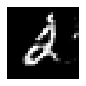

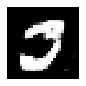

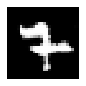

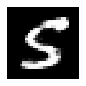

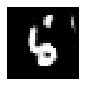

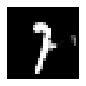

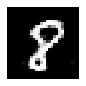

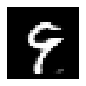

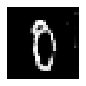

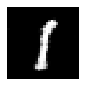

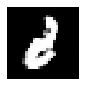

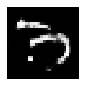

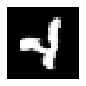

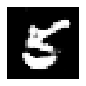

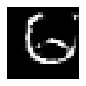

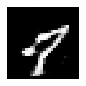

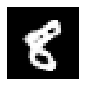

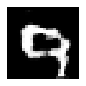

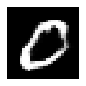

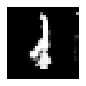

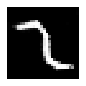

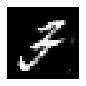

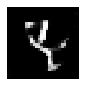

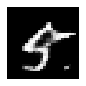

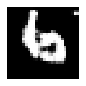

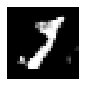

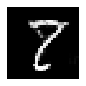

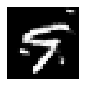

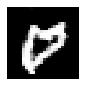

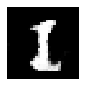

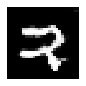

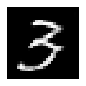

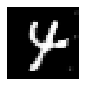

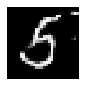

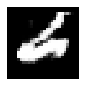

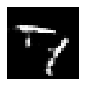

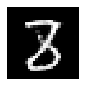

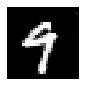

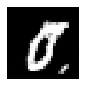

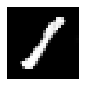

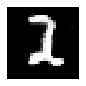

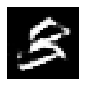

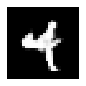

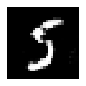

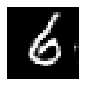

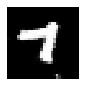

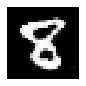

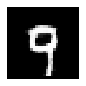

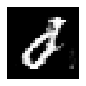

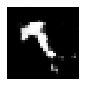

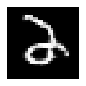

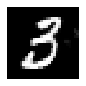

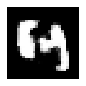

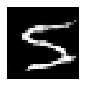

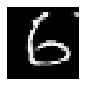

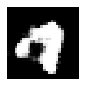

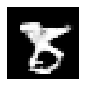

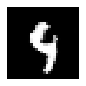

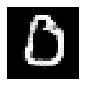

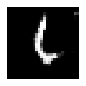

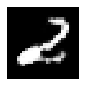

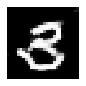

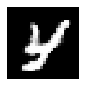

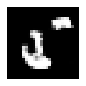

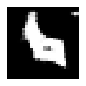

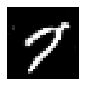

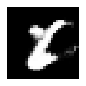

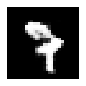

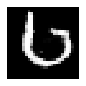

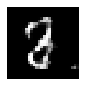

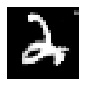

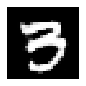

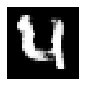

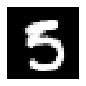

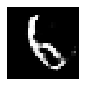

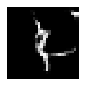

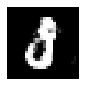

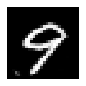

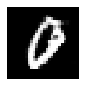

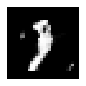

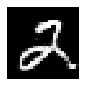

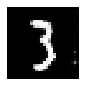

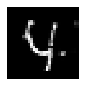

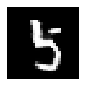

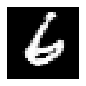

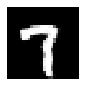

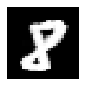

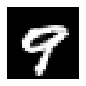

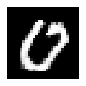

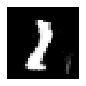

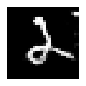

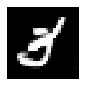

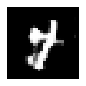

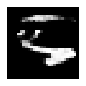

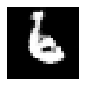

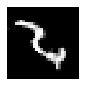

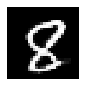

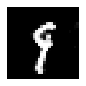

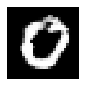

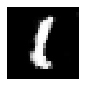

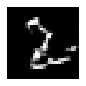

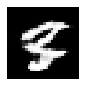

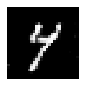

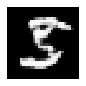

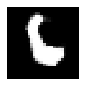

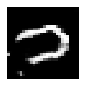

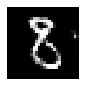

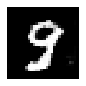

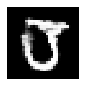

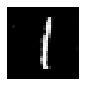

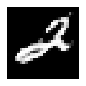

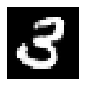

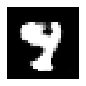

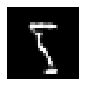

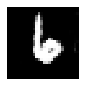

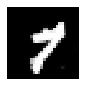

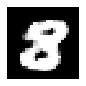

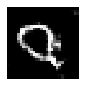

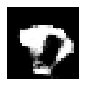

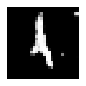

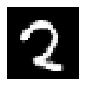

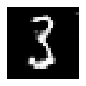

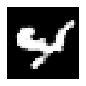

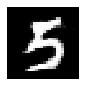

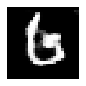

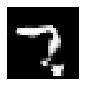

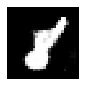

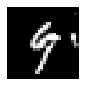

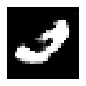

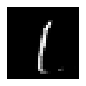

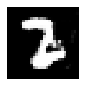

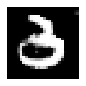

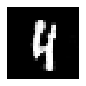

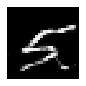

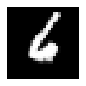

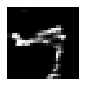

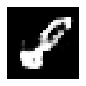

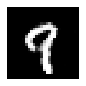

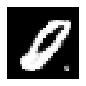

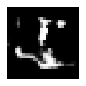

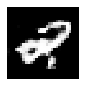

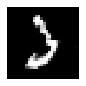

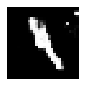

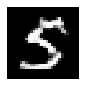

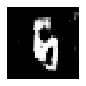

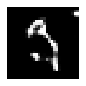

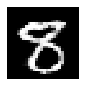

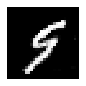

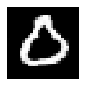

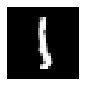

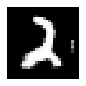

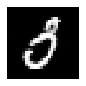

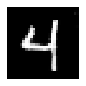

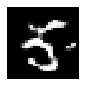

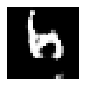

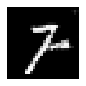

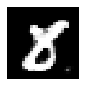

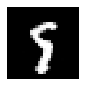

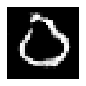

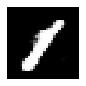

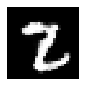

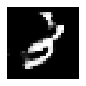

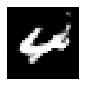

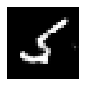

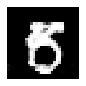

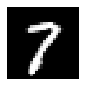

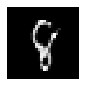

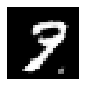

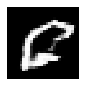

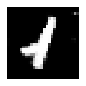

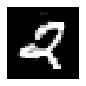

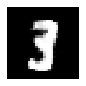

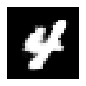

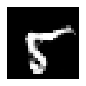

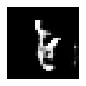

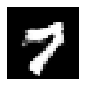

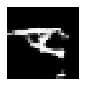

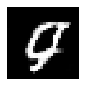

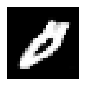

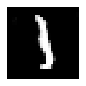

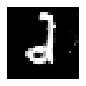

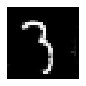

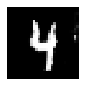

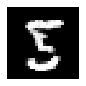

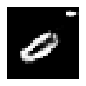

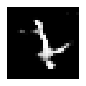

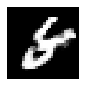

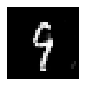

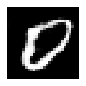

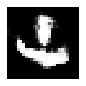

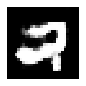

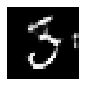

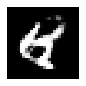

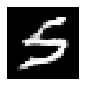

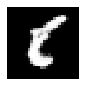

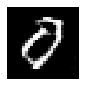

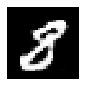

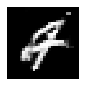

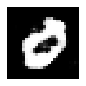

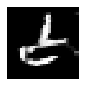

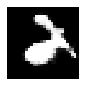

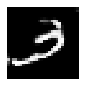

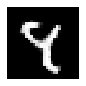

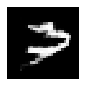

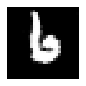

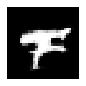

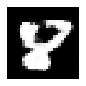

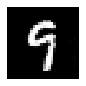

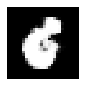

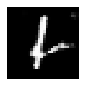

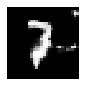

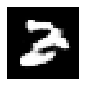

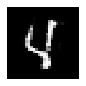

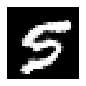

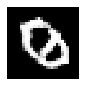

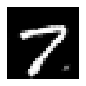

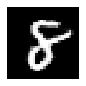

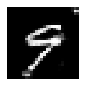

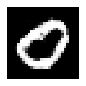

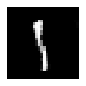

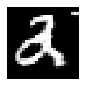

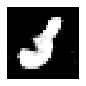

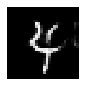

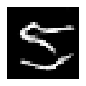

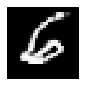

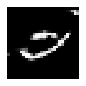

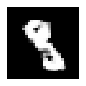

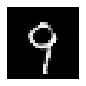

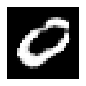

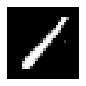

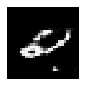

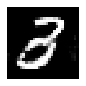

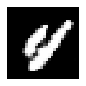

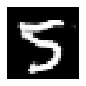

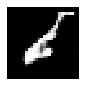

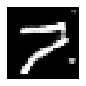

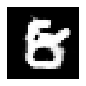

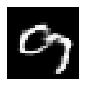

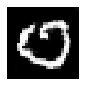

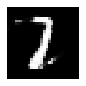

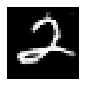

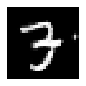

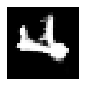

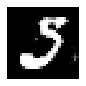

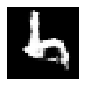

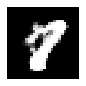

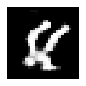

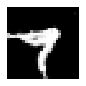

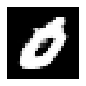

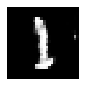

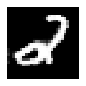

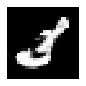

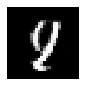

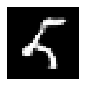

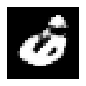

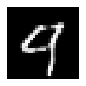

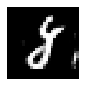

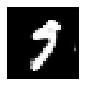

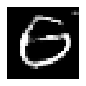

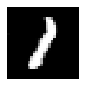

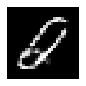

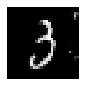

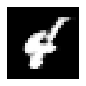

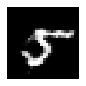

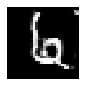

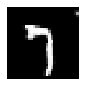

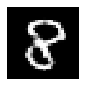

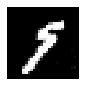

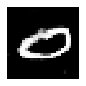

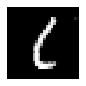

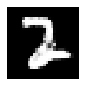

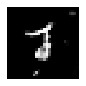

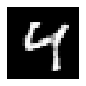

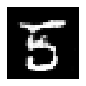

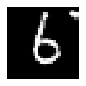

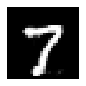

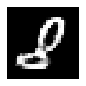

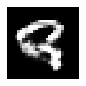

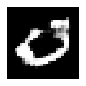

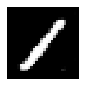

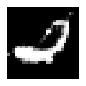

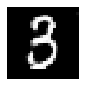

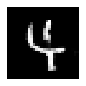

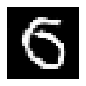

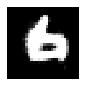

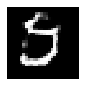

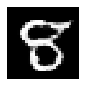

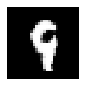

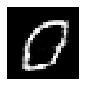

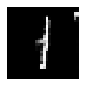

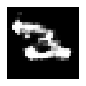

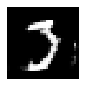

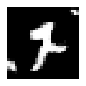

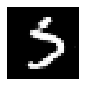

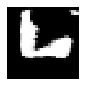

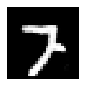

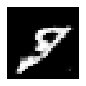

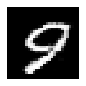

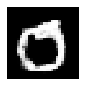

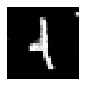

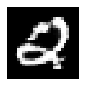

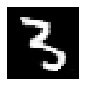

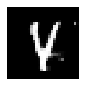

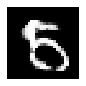

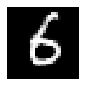

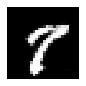

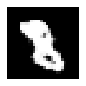

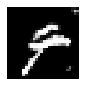

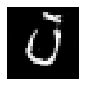

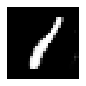

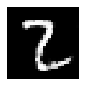

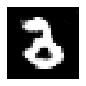

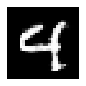

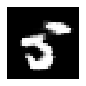

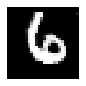

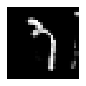

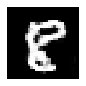

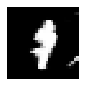

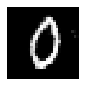

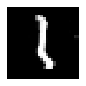

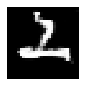

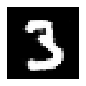

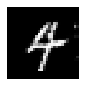

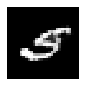

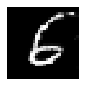

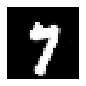

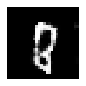

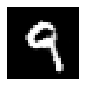

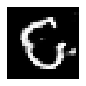

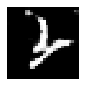

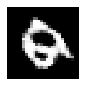

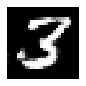

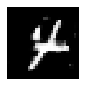

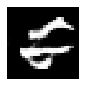

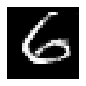

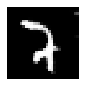

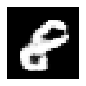

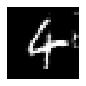

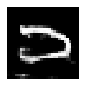

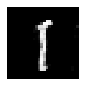

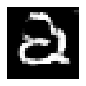

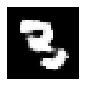

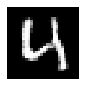

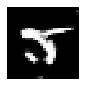

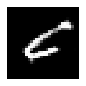

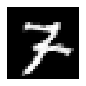

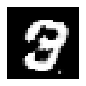

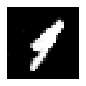

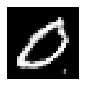

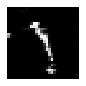

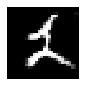

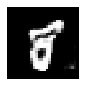

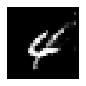

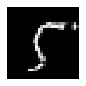

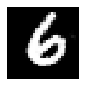

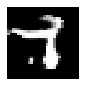

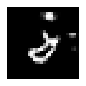

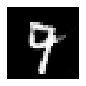

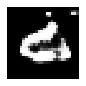

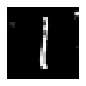

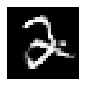

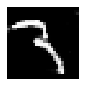

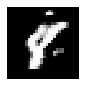

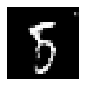

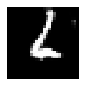

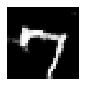

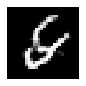

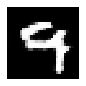

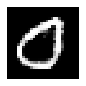

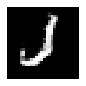

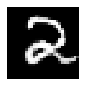

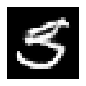

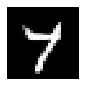

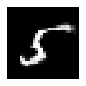

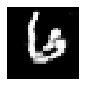

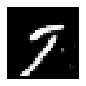

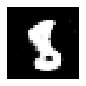

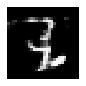

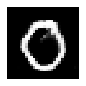

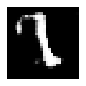

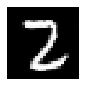

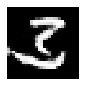

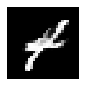

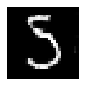

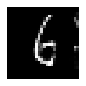

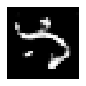

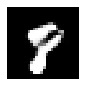

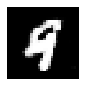

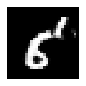

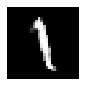

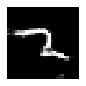

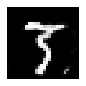

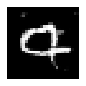

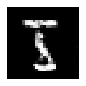

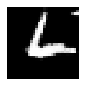

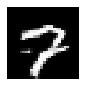

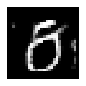

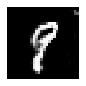

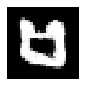

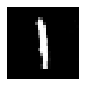

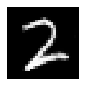

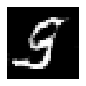

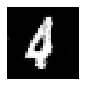

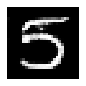

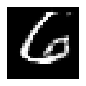

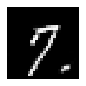

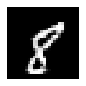

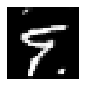

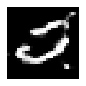

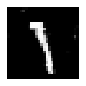

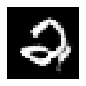

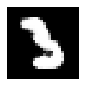

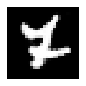

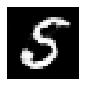

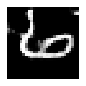

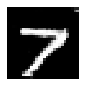

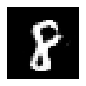

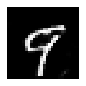

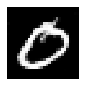

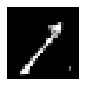

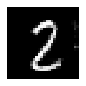

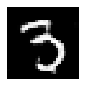

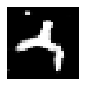

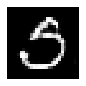

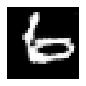

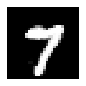

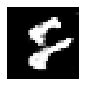

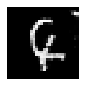

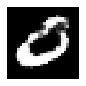

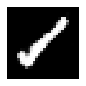

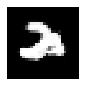

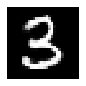

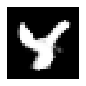

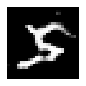

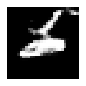

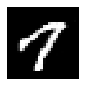

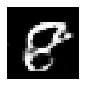

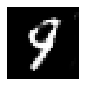

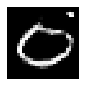

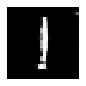

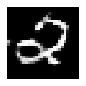

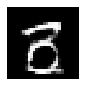

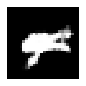

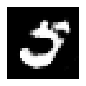

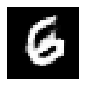

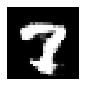

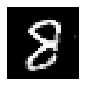

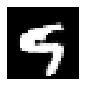

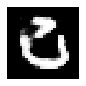

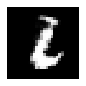

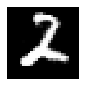

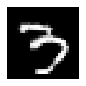

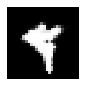

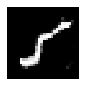

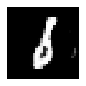

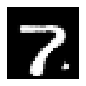

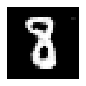

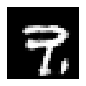

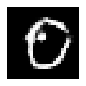

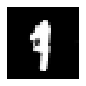

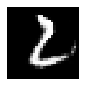

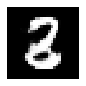

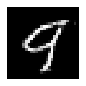

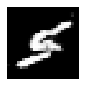

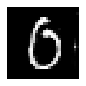

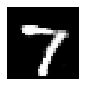

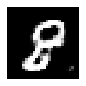

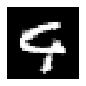

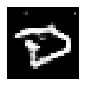

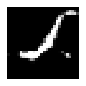

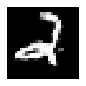

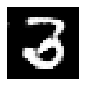

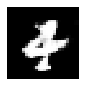

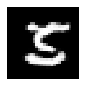

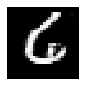

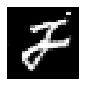

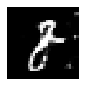

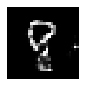

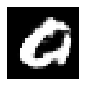

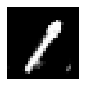

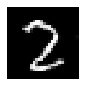

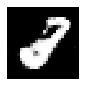

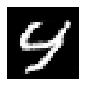

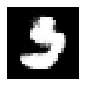

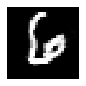

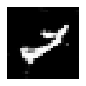

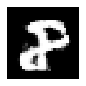

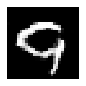

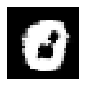

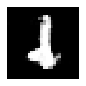

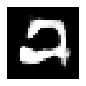

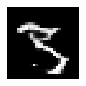

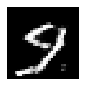

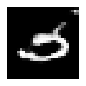

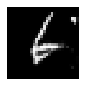

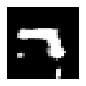

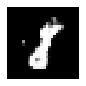

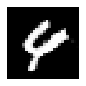

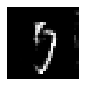

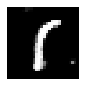

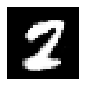

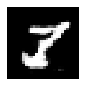

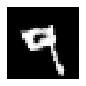

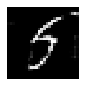

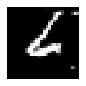

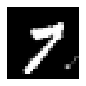

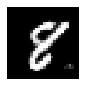

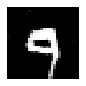

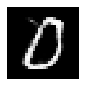

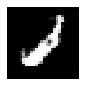

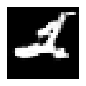

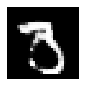

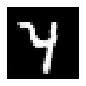

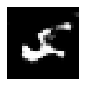

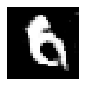

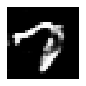

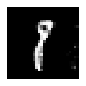

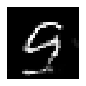

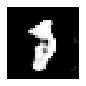

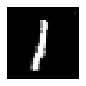

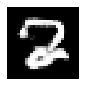

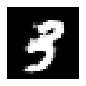

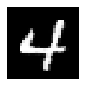

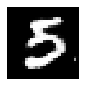

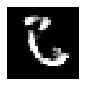

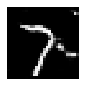

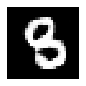

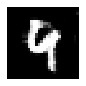

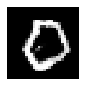

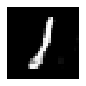

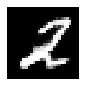

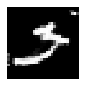

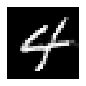

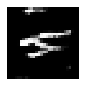

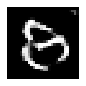

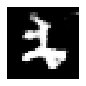

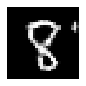

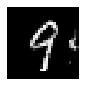

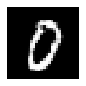

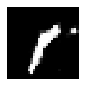

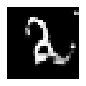

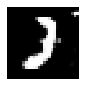

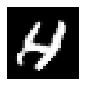

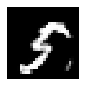

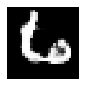

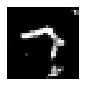

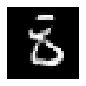

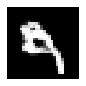

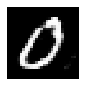

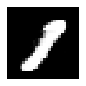

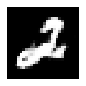

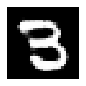

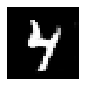

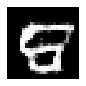

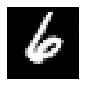

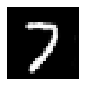

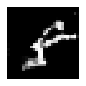

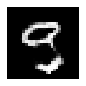

In [3]:
def generate_images():
    # load model
    model = load_model('generator_model_cgan_v2.h5')
    # generate images
    latent_points, labels = generate_latent_points(100, 1000)
    # specify labels
    labels = np.asarray([x for _ in range(100) for x in range(10)])
    with open('generated_labels.txt', 'w') as filehandle:
        filehandle.writelines("%d\n" % label for label in labels)
    labels = to_categorical(labels)
    # generate images
    X = model.predict([latent_points, labels])
    # scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    np.save("array.npy", np.array(X))
    np.save("noise.npy", np.array(latent_points))
    # plot the result
    save_plot(X, labels)

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]


# create and save a plot of generated images
def save_plot(examples, labels):
    for i in range(len(examples)):
        w = h = 1
        fig = plt.figure(frameon=False)
        fig.set_size_inches(w,h)
        
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)
        plt.set_cmap('gray')
        
        plt.imshow(examples[i, :, :, 0])
        fig.savefig('images/0/img_{}.png'.format(i))

generate_images()

Linear interpolation with noise and label for 0 and 1:


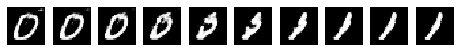

Linear interpolation with only noise


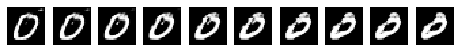

Linear interpolation with only label


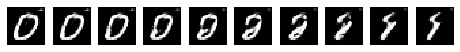

In [8]:
def save_plot(examples, number_of_subplots):
    fig=plt.figure(figsize=(8, 8))
    columns = number_of_subplots
    rows = 1
    for i in range(1, columns*rows +1):
        img = examples[(i-1), :, :, 0]
        fig.add_subplot(rows, columns, i)
        plt.axis("off")
        plt.imshow(img, cmap='gray')
    plt.show()
    
def interpolate(model, img1, img2, n1, n2, l1, l2, num_of_interpolations):
    alphaValues = np.linspace(0, 1, num_of_interpolations)
    vectors = [[] for i in range(0,3)]
    labels = [[] for i in range(0,3)]
    for alpha in alphaValues:
        # Latent space interpolation
        vector = n1*(1-alpha) + n2*alpha
        label = l1*(1-alpha) + l2*alpha
        #both noise and label
        vectors[0].append(np.array(vector))
        labels[0].append(np.array(label))
        
        #Only noise
        vectors[1].append(np.array(vector))
        labels[1].append(l1)
        
        #Only label
        vectors[2].append(n1)
        labels[2].append(label)
    
    sample_imgs = []
    sample_imgs1 = model.predict([vectors[0], labels[0]])
    sample_imgs2 = model.predict([vectors[1], labels[1]])
    sample_imgs3 = model.predict([vectors[2], labels[2]])

    sample_imgs.append(sample_imgs1)
    sample_imgs.append(sample_imgs2)
    sample_imgs.append(sample_imgs3)
    return(sample_imgs)

def get_generated_labels():
    labels = np.asarray([x for _ in range(100) for x in range(10)])
    with open('generated_labels.txt', 'w') as filehandle:
        filehandle.writelines("%d\n" % label for label in labels)
    return labels

#Get the saved generator model
model = load_model('generator_model_cgan_v2.h5')

#Load the saved generated images
generated_images = np.load("array.npy")
generate_images = generated_images.reshape(1000, 28, 28)

#Load the saved generated images' labels
labels = get_generated_labels()
labels = to_categorical(labels)

#Load the saved generated images' corresponding noise vectors
noise = np.load("noise.npy")

img1 = generated_images[100]
img2 = generated_images[121]

n1 = noise[100]
n2 = noise[121]

l1 = labels[100]
l2 = labels[121]

number_of_subplots = 10

#Interpolate for the selected labels
interpolation_result = interpolate(model, img1, img2, n1, n2, l1, l2, number_of_subplots)
titles = ["Linear interpolation with noise and label for 0 and 1:", "Linear interpolation with only noise", "Linear interpolation with only label"]

#Plot the interpolated images
for i, each in enumerate(interpolation_result):
    print(titles[i])
    save_plot(each, number_of_subplots)


In [10]:
#Data preparation for Binary classifier

def get_labels(filename):
    labels = []
    # open file and read the content in a list
    with open(filename, 'r') as filehandle:
        filecontents = filehandle.readlines()

        for line in filecontents:
            # remove linebreak which is the last character of the string
            current_place = line[:-1]

            # add item to the list
            labels.append(int(current_place))
    return labels

def get_real_and_generated_data():
    
    #Get real and generated labels
    generated_labels = get_labels('generated_labels.txt')
    real_labels = get_labels('real_labels.txt')
    
    #Get real and generated images
    generated_images = np.load("array.npy")
    real_images = np.load("real__images_array.npy")

    generated_images = generated_images.reshape(1000, 28, 28)
    real_images = real_images.astype('float64')

    #Normalize real images
    for idx, img in enumerate(real_images):
        real_images[idx] = img / 255.0
        
    return real_images, generated_images, real_labels, generated_labels

real_images, generated_images, real_labels, generated_labels = get_real_and_generated_data()

In [11]:
#Create false labels for half of the real and generated samples
def my_custom_random(label):
    exclude = label
    randInt = np.random.randint(0,9)
    return my_custom_random(label) if randInt == exclude else randInt

def assign_fake_labels(generated_labels, real_labels):
    for i in range(500,1000):
        temp1 = my_custom_random(generated_labels[i])
        generated_labels[i] = temp1
        
        temp2 = my_custom_random(real_labels[i])
        real_labels[i] = temp2
        
    return generated_labels, real_labels
  
generated_labels, real_labels = assign_fake_labels(generated_labels, real_labels)

#One-hot encode labels
generated_labels_oh = to_categorical(generated_labels)
real_labels_oh = to_categorical(real_labels)

In [12]:
#category for every pair :   real + real = 1    fake + real = 2   real + fake = 3   fake + fake = 4

#Form data for matching and non-matching image-label pair
matching_image_data = np.concatenate((generated_images[0:500], real_images[0:500]), axis=0)
matching_label_data = np.concatenate((generated_labels_oh[0:500], real_labels_oh[0:500]), axis=0)
matching_labels = [1 for i in range(0, 1000)]

non_matching_image_data = np.concatenate((generated_images[500:1000], real_images[500:1000]), axis=0)
non_matching_label_data = np.concatenate((generated_labels_oh[500:1000], real_labels_oh[500:1000]), axis=0)
non_matching_labels = [0 for i in range(0, 1000)]

#Assign one of the four categories for every image-label pair
def assign_category_for_every_pair():
    type_of_imglabel_pair = []
    for i in range(0, 2000):
        if i < 500:
            type_of_imglabel_pair.append(2)
        elif i >= 500 and i < 1000:
            type_of_imglabel_pair.append(1)
        elif i >= 1000 and i < 1500:
            type_of_imglabel_pair.append(4)
        else:
            type_of_imglabel_pair.append(3)
    return type_of_imglabel_pair
        
type_of_imglabel_pair = assign_category_for_every_pair()

#Join the input with corresponding labels as a tuple to shuffle the data
data1 = list(zip(matching_image_data, matching_label_data, matching_labels, type_of_imglabel_pair[:1000]))
data2 = list(zip(non_matching_image_data, non_matching_label_data, non_matching_labels, type_of_imglabel_pair[1000:2000]))
final_data = data1 + data2

np.random.shuffle(final_data)

In [13]:
temp = list(zip(*final_data))
X_image, X_label, y, pair_type = temp[0], temp[1], temp[2], temp[3]
X = tuple(zip(X_image, X_label))
y = tuple(zip(y, pair_type))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

temp2 = list(zip(*y_train))
y_train = list(temp2[0])
y_test = list(y_test)

temp1 = list(zip(*X_train))
temp2 = list(zip(*X_test))

X_train_images, X_train_labels = np.asarray(temp1[0]).reshape([1600, 28, 28]), np.asarray(temp1[1])
X_test_images, X_test_labels = np.asarray(temp2[0]), np.asarray(temp2[1])

X_train_images = [img.flatten() for img in X_train_images]
X_test_images = [img.flatten() for img in X_test_images]


In [14]:
image_resize = 28 // 4

input1 = Input(shape=(28*28,), name='image_input')
input2 = Input(shape=(10,), name='class_labels')

x = concatenate([input1, input2], axis=1)
x = Dense(image_resize * image_resize * 128)(x)

merge_one = Dense(512, activation='relu', name='fc2')(x)
merge_one = Dropout(0.3)(merge_one)
merge_one = Dense(512, name='fc3')(merge_one)

merge_one = Activation('relu', name="Activation_required")(x)
predictions = Dense(1, activation='sigmoid')(merge_one)
    
model = Model(inputs=[input1, input2], outputs=predictions)
model.summary()
adam = Adam(lr=1e-3, epsilon = 1e-8, beta_1 = .9, beta_2 = .999)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit([X_train_images, X_train_labels], y_train, epochs=5, batch_size=32)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        (None, 784)          0                                            
__________________________________________________________________________________________________
class_labels (InputLayer)       (None, 10)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 794)          0           image_input[0][0]                
                                                                 class_labels[0][0]               
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 6272)         4986240     concatenate_1[0][0]        

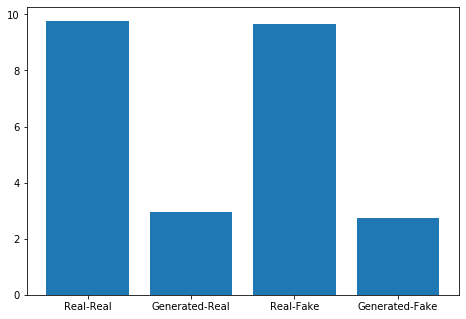

<Figure size 432x288 with 0 Axes>

In [15]:
# Get intermediate activations
def get_activations(layer_name, model, X_test_images, X_test_labels):
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output) 
    intermediate_output = intermediate_layer_model.predict([X_test_images, X_test_labels])
    return intermediate_output

def get_activation_set_for_all_categories(activations, imglabel_category_type):
    y_test_type = [i[1] for i in imglabel_category_type]
    intermediate_output = list(zip(activations, y_test_type))
    real_real = []
    real_fake = []
    gen_real = []
    gen_fake = []
    for i in range(0, 400):
        if intermediate_output[i][1] == 1:
            real_real.append(intermediate_output[i][0])
        elif intermediate_output[i][1] == 2:
            gen_real.append(intermediate_output[i][0])
        elif intermediate_output[i][1] == 3:
            real_fake.append(intermediate_output[i][0])
        else:
            gen_fake.append(intermediate_output[i][0])
    return real_real, gen_real, real_fake, gen_fake

def get_average_activation_distance(real_real, gen_real, real_fake, gen_fake):
    #Calculate euclidean distance between activation vectors

    g1 = distance.pdist(real_real, metric='euclidean') 
    g2 = distance.pdist(gen_real, metric='euclidean') 
    g3 = distance.pdist(real_fake, metric='euclidean') 
    g4 = distance.pdist(gen_fake, metric='euclidean') 

    #todo variable n
    a1 = np.average(g1)
    a2 = np.average(g2)
    a3 = np.average(g3)
    a4 = np.average(g4)
    
    return a1, a2, a3, a4

# Get activations from second last layer
intermediate_output = get_activations('Activation_required', model, X_test_images, X_test_labels)

#Divide activations in four sets
real_real, gen_real, real_fake, gen_fake = get_activation_set_for_all_categories(intermediate_output, y_test)

#Calculate average distance for all four pairs of inputs
avg1, avg2, avg3, avg4 = get_average_activation_distance(real_real, gen_real, real_fake, gen_fake)

#Results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
categories = ['Real-Real', 'Generated-Real', 'Real-Fake', 'Generated-Fake']
distances = [avg1, avg2, avg3, avg4]
ax.bar(categories,distances)
plt.show()
plt.savefig('Distance.png')